# **Exploratory Visualizations** 🐲🐲🐲

The driving goal in everything that we do in the modeling process is to <u style="color: #B00; font-weight: bolder">find reproducible ways to explain the variation in the response!</u>
The focus of this chapter will be to present approaches for visually exploring data and to demonstrate how this approach can be used to **help guide feature engineering**.

When doing a predictive modeling with a response $Y$, we
- Start with the response and explore its characteristics, distribution and properties
- After that, we move to the information the predictors give

Knowledge about the response we can gain by using a **boxplot, histogram or a density plot**. That way we can see tha distribution and the variation in the response.

Next, we can move on to exploring **relationships among the predictors** and between predictors and the response. 

### **Important characteristics can be identified by examining** 📄

- scatter plots of individual predictors and the response
- a pairwise correlation plot among the predictors
- a projection of high-dimensional predictors into a lower dimensional space
- line plots for time-based predictors ⏲
- the first few levels of a regression or classification tree 🎄
- a heat map across the samples and predictors 🌞🗺️
- mosaic plots for examining associations among categorical variables 

These visualizations provide insights that should be used to inform the initial models.

In fact, a simple scatter plot can elicit insights that a model may not be able to uncover, and can lead to the creation of a new predictor or to a transformation of a predictor or the response that improves model performance.

In this chapter, we will delve into a variety of useful visualization tools for exploring data prior to constructing the initial model. 

<hr>

### **The Data and the Process** 🏋
- The data contains daily ridership data were obtained for 126 stations between January 22, 2001 and September 11, 2016.
- Ridership is measured by the number of entries into a station across all turnstiles
- For ease of presentation, ridership will be shown and analyzed in units of thousands of riders
- Our illustration will narrow to predicting daily ridership at the <u style="color: #B00; font-weight: bolder">Clark/Lake</u> stop (**it's an important central station**).
- Since goal is to predict future ridership volume, only historical data would be available at the time of prediction.

### **Predictors we might use are**

- Laggings are often used as predictors for time series data $(D-14)$
- Gasoline price 🚗
- Unemployment rate 👷
- Weather (18 predictors were obtained)
    - overcast
    - freezing rain 🥶
    - snow 🌨
    - rain, snow/ice, clouds 🌩, storms, and clear skies 🌨
    - temperature (daily min, max, median, mean), dew point, humidity, air pressure, precipitation and wind speeds

New predictors were encoded by summarizing the hourly data across a day by calculating the percentage of observations within a day where the conditions were observed. As an illustration, on December 20, 2012, conditions were recorded as snowy (12.8% of the day), cloudy (15.4%), as well as stormy (12.8%), and rainy (71.8%).

In [1]:
# 🐼🐼🐼 pandas and numpy 🐼🐼🐼
import pandas as pd
import numpy as np

# pipelines and transformers 🧰
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from pca import pca as pca_helper

# hypothesis testing tools 🧰
from scipy.stats import ttest_ind, pearsonr, chi2, chi2_contingency

# visualization tools 👨‍🎨
from matplotlib import pyplot as plt
from matplotlib import cm
from datetime import timedelta

import joypy

from ipywidgets import interact, Dropdown

 
# ggplot layers
from plotnine import (ggplot, aes, geom_violin, coord_flip, geom_tile, geom_point, geom_segment,
                      geom_boxplot, theme, element_blank, geom_path, geom_hline, xlim,
                      scale_fill_manual, geom_errorbar, geom_line, geom_bar, scale_x_log10,
                      scale_color_manual, geom_histogram, ggtitle, geom_density, geom_jitter,
                      facet_wrap,  xlab, ylab, scale_x_discrete)

# for setting plot size mainly
import plotnine.options as ggplot_options

%matplotlib inline

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [2]:
# load the data 
trains_df = pd.read_csv("./data/train_plot_data.csv")
station_rides_df = pd.read_csv("./data/station_rides.csv")
stations_df = pd.read_csv("./data/stations.csv")

# show dimensions
print("Dimension is " + str(trains_df.shape))

# define some constants
DAILY_RIDES_COLUMN = 's_40380'

# glimpse into the data
trains_df.head(5)

Dimension is (5698, 1093)


,Unnamed: 0,s_40380,dow,doy,week,month,year,Advent1st,Advent2nd,Advent3rd,...,Bulls_Home,Bears_Away,Bears_Home,WhiteSox_Away,WhiteSox_Home,Cubs_Away,Cubs_Home,l14_gas_price,l30_unemployment_rate,date
0,1,15.732,Mon,22,4,Jan,2001,0,0,0,...,0,0,0,0,0,0,0,1.516,NaN,2001-01-22
1,2,15.762,Tue,23,4,Jan,2001,0,0,0,...,1,0,0,0,0,0,0,1.516,NaN,2001-01-23
2,3,15.872,Wed,24,4,Jan,2001,0,0,0,...,0,0,0,0,0,0,0,1.516,NaN,2001-01-24
3,4,15.874,Thu,25,4,Jan,2001,0,0,0,...,0,0,0,0,0,0,0,1.516,NaN,2001-01-25
4,5,15.423,Fri,26,4,Jan,2001,0,0,0,...,0,0,0,0,0,0,0,1.516,NaN,2001-01-26


### **Adding some additional helper columns** 

In [3]:
trains_df['date'] = pd.to_datetime(trains_df['date'])
trains_df['date_14d_prior'] = trains_df['date'] - timedelta(days=14)

trains_df['dom'] = trains_df['date'].dt.day
trains_df['moy'] = trains_df['date'].dt.month.apply(lambda x: '{0:0>2}'.format(x))
trains_df['dom_label'] = pd.cut(trains_df['dom'], bins=[0, 15, 32], labels=["01", "15"])
trains_df['md_label'] = trains_df['moy'].astype(str) + "-" + trains_df['dom_label'].astype(str)

trains_df['pow'] = np.where(trains_df['dow'].isin(['Sat', 'Sun']), 'Weekend', 'Weekday')

trains_df['year'] = trains_df['year'].astype('category')

trains_df['month'] = pd.Categorical(
    trains_df['month'], 
    categories=["Jan", "Feb", "Mar", "Jun", "May", "July", "Aug", "Sep", "Oct", "Nov", "Dec"],
    ordered=True
) 

## **4.2 Visualizations for Numeric Data: Exploring Train Ridership Data** 🚅🚅🚅

### **4.2.1 Box Plots, Violin Plots, and Histograms**

Because the foremost goal of modeling is to understand variation in the response, the first step should be to understand the distribution of the response.

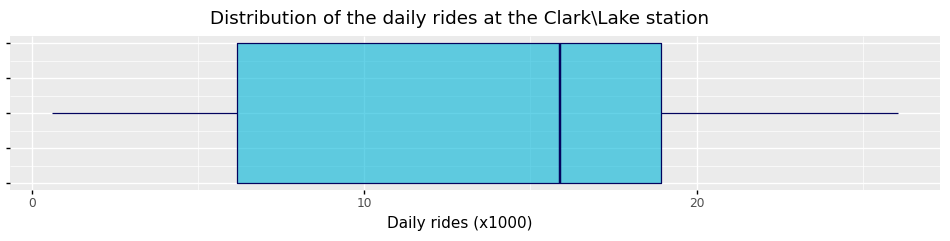

<ggplot: (315068094)>

In [4]:
ggplot_options.figure_size = (12, 2)

(ggplot(trains_df) +
    aes(x=0, y=DAILY_RIDES_COLUMN) +
    geom_boxplot(fill="#00b4d8", color="#03045e", alpha=0.6, width=0.01) +
    ggtitle("Distribution of the daily rides at the Clark\\Lake station") +
    coord_flip() +
    ylab("Daily rides (x1000)") +
    xlab("") +
    theme(axis_text_y=element_blank(), axis_ticks_minor_y=element_blank())
)

A drawback of the box plot is that it is not effective at identifying distributions that have multiple peaks or modes. In that sense, a histogram or a density plot might be better.

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 18'. Pick better value with 'binwidth'.


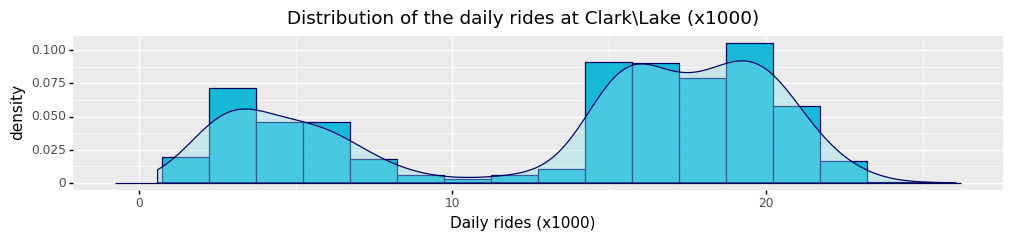

<ggplot: (315168781)>

In [5]:
(ggplot(trains_df) +
    aes(x=DAILY_RIDES_COLUMN) +
    geom_histogram(aes(y='stat(density)'), alpha=.9, fill="#00b4d8", color="#03045e") +
    geom_density(fill='#90e0ef', color="#03045e", alpha=0.4) +
    ggtitle("Distribution of the daily rides at Clark\\Lake (x1000)") +
    xlab("Daily rides (x1000)")
)

In the disribution there are two peaks, which indicates there might be two mechanisms generating the number of rides. To retain the properties of the boxplot, we can use a violin plot as well.

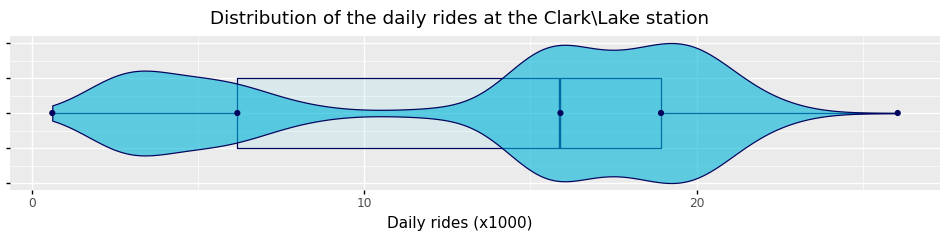

<ggplot: (315067874)>

In [6]:
(ggplot(trains_df) +
    aes(x=0, y=DAILY_RIDES_COLUMN) +
    geom_boxplot(color="#03045e", fill="#90e0ef", width=0.005, position = 'dodge', alpha=0.2) +
    geom_violin(fill="#00b4d8", color="#03045e", alpha=0.6, width=0.01) +
    geom_point(
        mapping=aes(x='x', y='y'),
        data=pd.DataFrame({'x': 0, 'y': np.quantile(trains_df[DAILY_RIDES_COLUMN], q=[0, 0.25, 0.5, 0.75, 1])}),
        color="#03045e"
    ) +
    ggtitle("Distribution of the daily rides at the Clark\\Lake station") +
    coord_flip() +
    ylab("Daily rides (x1000)") +
    xlab("") +
    theme(axis_text_y=element_blank(), axis_ticks_minor_y=element_blank())
)

We can see that there might be two peaks in the second peak as well.

Examining the distribution of each predictor can help to guide our decisions about the need to engineer the features through transformation prior to analysis.

When we have a moderate number of predictors (< ~100) and when the predictors are on the same order of magnitude, we can visualize the distributions simultaneously using side-by-side box or violin plots.

## **Boxplots (or Violins) for different stations` weekday rides** 🎻🎻🎻

In [7]:
ggplot_options.figure_size = (12, 18)

type_dropdown = Dropdown(options = ['Boxplots', 'Violins', 'Densities'])

# create the median_rides dataframe in order to sort the boxplots
median_rides_df = (station_rides_df[['description', 'Rides']]
    .groupby('description')
    .median()
    .sort_values(by='Rides', ascending=False)
    .reset_index()
)

# change variable type to categorical (better visualizations)
station_rides_df['description'] = pd.Categorical(
    station_rides_df['description'],
    categories=median_rides_df['description']
)

def plot_distributions():
    return joypy.joyplot(
        station_rides_df,
        by="description",
        column="Rides",
        range_style='own', 
        grid="y",
        linewidth=1,
        legend=False,
        figsize=(12, 18),
        title="Weekday Ride Densities for different stations",
        colormap=cm.autumn_r
    );

def plot_box_and_violins(Plot):
    return (ggplot(station_rides_df) +
        aes(x='description', y='Rides', fill='description') +
        (geom_boxplot() if Plot == 'Boxplots' else geom_violin()) +
        coord_flip() +
        theme(legend_position='none') +
        xlab("Station") +
        ylab("Rides (x1000)") +
        ggtitle("Weekday Ride Boxplots for different stations")
    )

@interact(Plot = type_dropdown)
def plot_rides(Plot):
    if Plot == 'Densities':
        return plot_distributions(); 
    else:
        return plot_box_and_violins(Plot)



interactive(children=(Dropdown(description='Plot', options=('Boxplots', 'Violins', 'Densities'), value='Boxplo…

#### **Several characteristics stand out:**

- variability in ridership increases with the median ridership
- there are a number of unusually low and unusually high values for each station
- and a few stations have distinctly large variation

One station particularly stands out, which is about one-quarter of the way from the left. This happens to be the Addison station which is the nearest stop to Wrigley Field. The wider distribution is due to ridership associated with the weekday home games for the Chicago Cubs, with attendance at its peak reaching close to the most frequently traveled stations. If the goal was to predict ridership at the Addison station, then the Cubs’ home game schedule would be important information for any model. The unusually low values for the majority of the stations will be discussed next.

## **Augmenting Visualizations through Faceting, Colors, and Shapes**


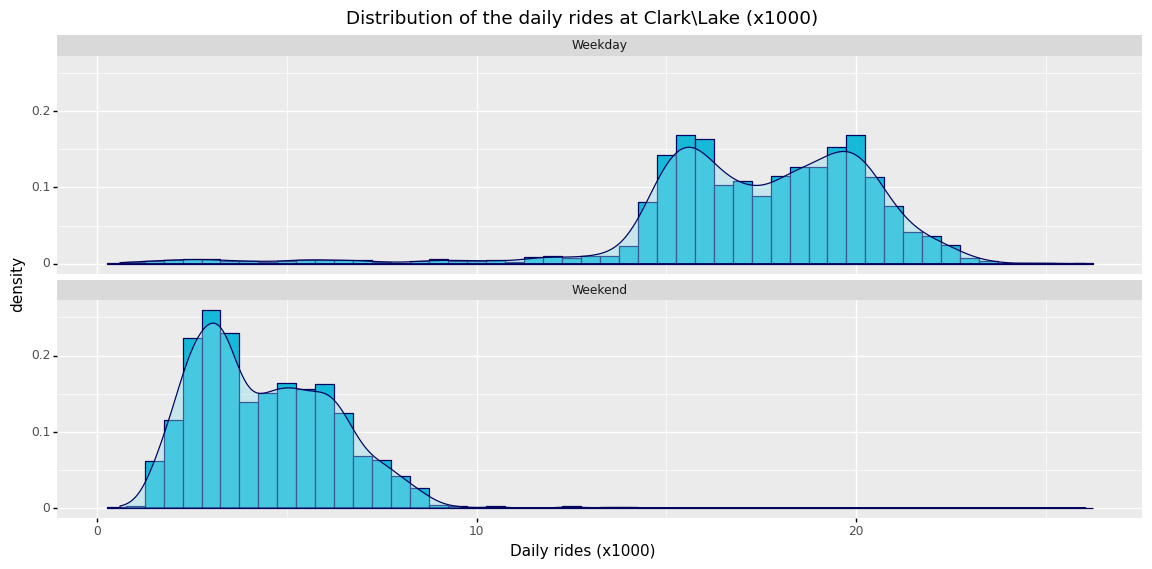

<ggplot: (315169383)>

In [8]:
ggplot_options.figure_size = (14, 6)

(ggplot(trains_df) +
    aes(x=DAILY_RIDES_COLUMN, fill='pow') +
    geom_histogram(aes(y='stat(density)'), binwidth=0.5, alpha=.9, fill="#00b4d8", color="#03045e") +
    geom_density(alpha=.4, fill="#90e0ef", color="#03045e") +
    ggtitle("Distribution of the daily rides at Clark\\Lake (x1000)") +
    xlab("Daily rides (x1000)") +
    facet_wrap("pow", nrow=2) +
    theme(legend_position='none')
)

Careful viewing of the weekday ridership distribution should draw our eye to a long tail on the left which is a result of a number of days with lower ridership similar to the range of ridership on weekends.

<u style="color: #B00; font-weight: bolder">What might be the cause for the low outliers on the Weekdays and the high outlers on the Weekends? If we can figure that out, we might be able to do some good feature engineering.</u>

**A model that has the ability to explain these lower values will have better predictive performance than a model that does not.** 🤓

## **4.2.3 Scatter Plots**

Augmenting visualizations through the use of faceting, color, or shapes is one way to incorporate an additional dimension in a figure. Another approach is to directly add another dimension to a graph. 

If the goal is to predict ridership at the Clark/Lake station then we could anticipate that **recent past ridership information** should be related to current ridership. That is to say another potential predictor to consider would be the 
- previous day’s  ridership information, or 
- previous week’s.

Because we know that weekday and weekend have different distributions, a one-day lag would be less useful for predicting ridership on Monday or Saturday.

**Because the primary interest is in predicting ridership two weeks in advance, we will create the 14-day lag in ridership for the Clark/Lake station.**

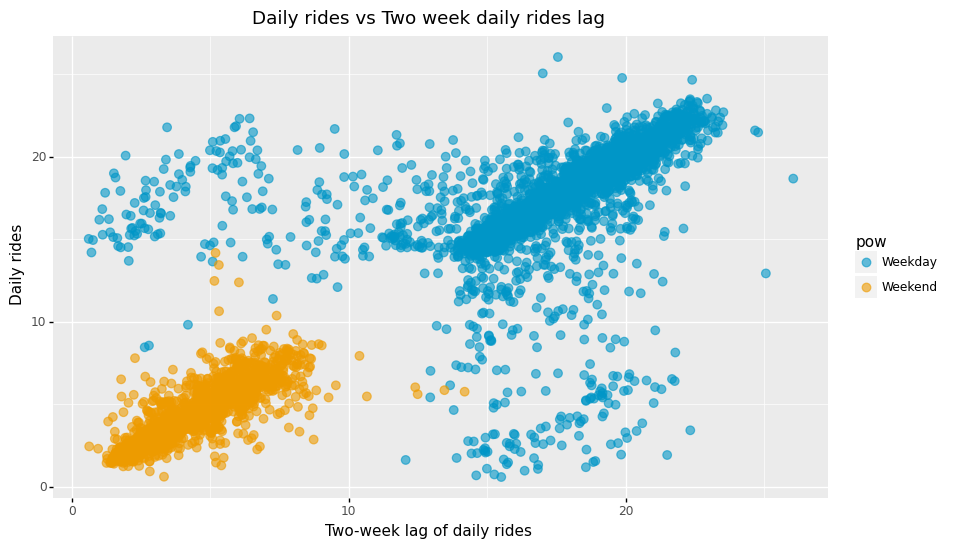

<ggplot: (315213572)>

In [9]:
LAG_14_COLUMN = 'l14_40380'

ggplot_options.figure_size = (10, 6)

(ggplot(trains_df) +
    aes(x=LAG_14_COLUMN, y=DAILY_RIDES_COLUMN, color='pow') +
    geom_point(size=3, alpha=0.6) +
    ggtitle("Daily rides vs Two week daily rides lag") +
    xlab("Two-week lag of daily rides") +
    ylab("Daily rides") +
    scale_color_manual(values=["#0096c7", "#ee9b00"])
)

This figure highlights several characteristics that we need to know: there is a strong linear relationship between the 14-day lag and current-day ridership, there are two distinct groups of points (due to the part of the week), and there are many 14-day lag/current day pairs of days that lie far off from the overall scatter of points. These results indicate that the 14-day lag will be a crucial predictor for explaining current-day ridership. <u style="color: #B00; font-weight: bolder">Moreover, uncovering the explanation of samples that are far off from the overall pattern visualized here will lead to a new feature that will be useful as a input to models.</u>

## **4.2.4 Heatmaps**

**Low weekday ridership as illustrated in Figure 4.5 might be due to annual occurrences; to investigate this hypothesis, the data will need to be augmented.**

A question we might asked ourselves is 
"When people are not travelling during the weekday?" $\to$ "When they are not going to work" $\to$ "When are they not going to work?" $\to$ "When they've taken a vacation or if it's a national holiday" $\to$ The holidays are something affecting the entire population.

### **Exploring on the unusual values**

1. The first step is to create an indicator variable for weekdays with ridership less than 10,000 or greater than or equal to 10,000.

2. We then need a visualization that allows us to see when these unusual values occur. A visualization that would elucidate annual patterns in this context is a heatmap.

For the ridership data, we will create a month and day predictor, a year predictor, and an indicator of weekday ridership less than 10,000 rides.

Then we'll use a **heatmap**.

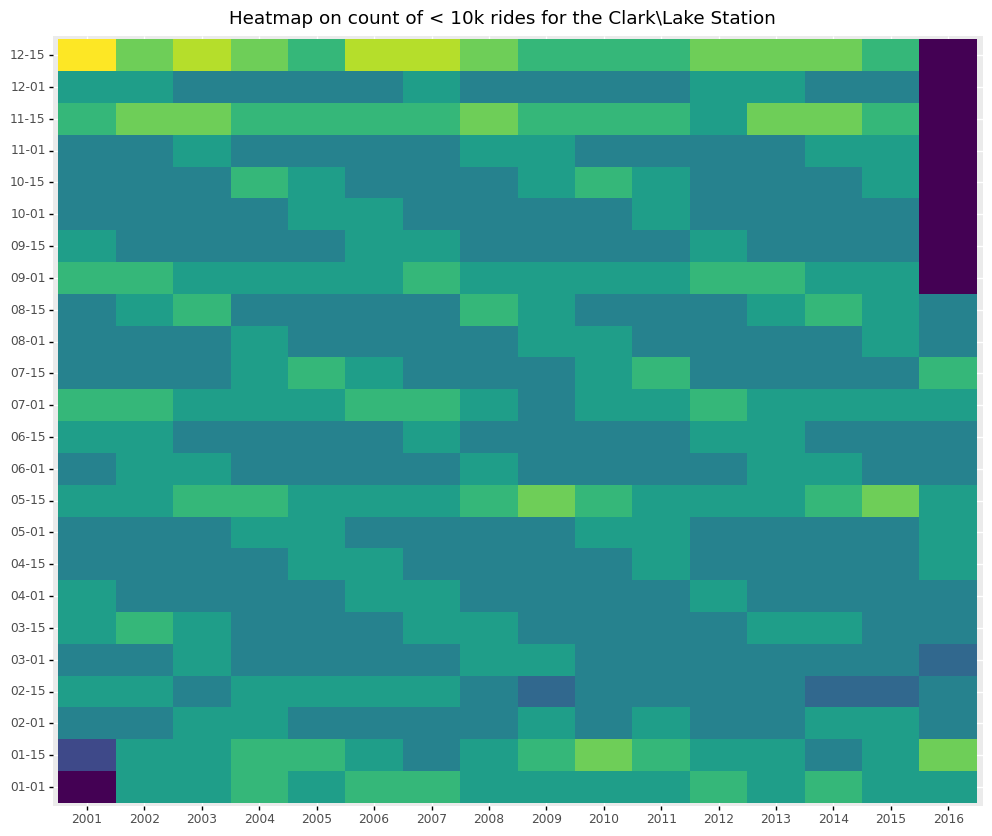

<ggplot: (315026987)>

In [10]:
ggplot_options.figure_size = (12, 10)

is_weekend = trains_df['pow'].isin(["Sat", "Sun"])
is_lt_10k = trains_df[DAILY_RIDES_COLUMN] < 10

(trains_df
  .assign(less_than_10=((is_lt_10k) & (~is_weekend)).astype(int))
  .groupby(['year', 'md_label'])
  .sum()
  .reset_index()[['year', 'md_label', 'less_than_10']]
  .assign(year=lambda df: df['year'].astype(str))
  .pipe(ggplot) +
     ggtitle("Heatmap on count of < 10k rides for the Clark\\Lake Station") +
     aes(x='year', y='md_label', fill='less_than_10') +
     theme(legend_position = "none") +
     geom_tile() +
     ylab("") +
     xlab("")
)

Now that we understand the effect of major US holidays, these values will be excluded from the scatter plot of 14-day lag versus current-day ridership.

### **Loading the holidays dataset**

In [11]:
holidays_df = pd.read_csv("./data/holidays.csv")
holidays_df.date = pd.to_datetime(holidays_df.date)

### **Visualizing without the holidays**

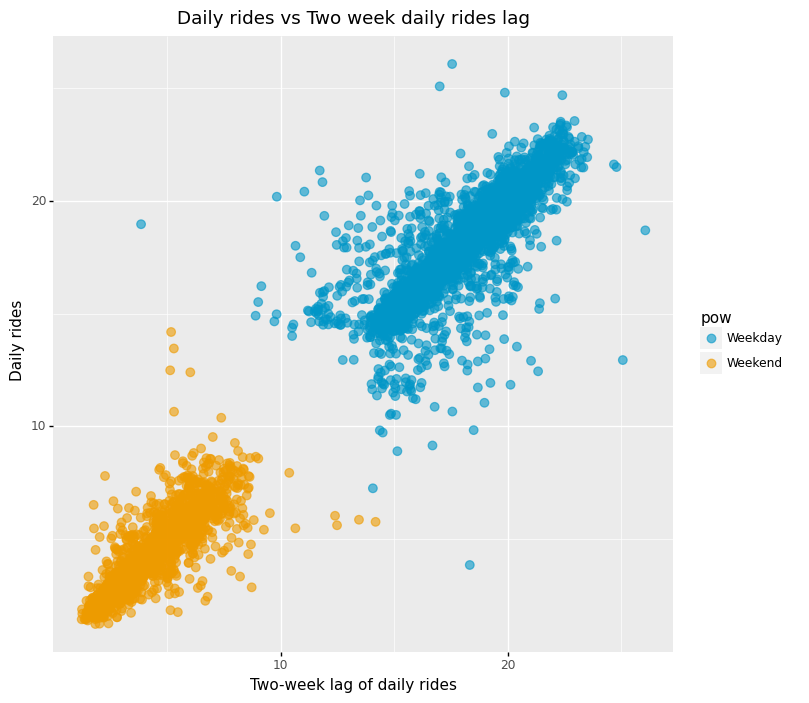

<ggplot: (315750105)>

In [12]:
ggplot_options.figure_size = (8, 8)

trains_hd_df = pd.merge(
    pd.merge(trains_df, holidays_df),
    holidays_df.rename(columns=lambda x: x + "_14d_prior"),
    how='left',
    left_on='date_14d_prior',
    right_on='date_14d_prior'
).assign(
    is_holiday=lambda df: (df['common_holiday'] == 'Holiday') | (df['common_holiday_14d_prior'] == 'Holiday')
)

(ggplot(trains_hd_df[~trains_hd_df['is_holiday']]) +
    aes(x=LAG_14_COLUMN, y=DAILY_RIDES_COLUMN, color='pow') +
    geom_point(size=3, alpha=0.6) +
    ggtitle("Daily rides vs Two week daily rides lag") +
    xlab("Two-week lag of daily rides") +
    ylab("Daily rides") +
    scale_color_manual(values=["#0096c7", "#ee9b00"])
)

Now that we have finally removed the holidays, we can see that the dependence is a lot more linear.

## **Correlation Matrix Plots**

This plot is currently missing. We should add it.


## **Line plots**

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 4 rows containing missing values.
/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


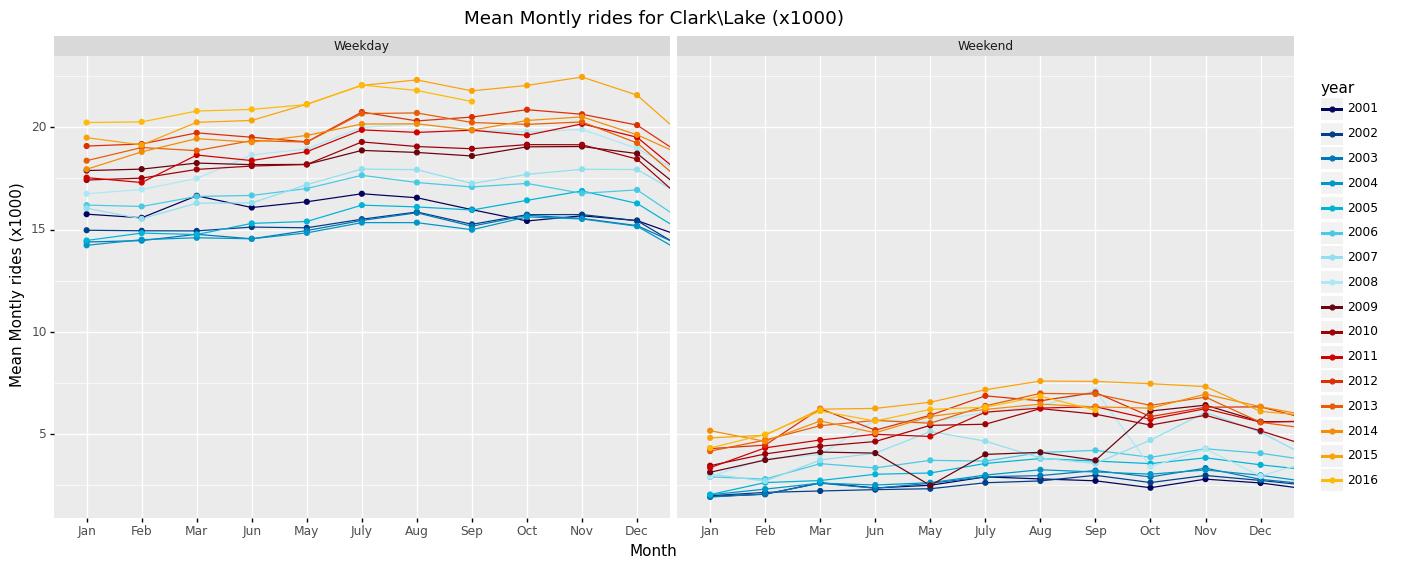

<ggplot: (315505722)>

In [13]:
ggplot_options.figure_size = (16, 6)

(trains_hd_df[~trains_hd_df['is_holiday']]
 .assign(month=lambda df: df['date'].dt.month)
#  trains_df['date'].dt.month_name()
 .groupby(['year', 'month', 'pow'])
 .mean()
 .reset_index()[
    ['year', 'month', 'pow', DAILY_RIDES_COLUMN]
 ]
 .pipe(ggplot) +
   aes(x='month', y=DAILY_RIDES_COLUMN, color='year') +
   geom_line() +
   geom_point() +
   facet_wrap('pow', ncol=2) +
   scale_x_discrete(
       name ="Month", 
      limits=["Jan", "Feb", "Mar", "Jun", "May", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
   ) +
   ggtitle("Mean Montly rides for Clark\\Lake (x1000)") +
   ylab("Mean Montly rides (x1000)") +
   scale_color_manual(values=[
      "#03045e", "#023e8a", "#0077b6", "#0096c7", "#00b4d8", "#48cae4", "#90e0ef", "#ade8f4",
      "#6a040f", "#9d0208", "#d00000", "#dc2f02", "#e85d04", "#f48c06", "#faa307", "#ffba08"
   ])
)

Here we see that since 2001, ridership has steadily increased during weekdays and weekends. This would make sense because the population of the Chicago metropolitan area has increased during this time period (United States Census Bureau 2017). The line plot additionally reveals that within each year ridership generally increases from January through October then decreases through December. These findings imply that the time proximity of ridership information should be useful to a model. That is, understanding ridership information within the last week or month will be more useful in predicting future ridership.

We can also see that weekend ridership exhibits much more variation. For example years 2008 and 2009 have very high jumps in variation.

A potential driver for increased ridership on public transportation is gasoline prices

In [14]:
GAS_PRICE_14_DAYS_LAG_COLUMN = 'l14_gas_price'

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 4 rows containing missing values.
/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


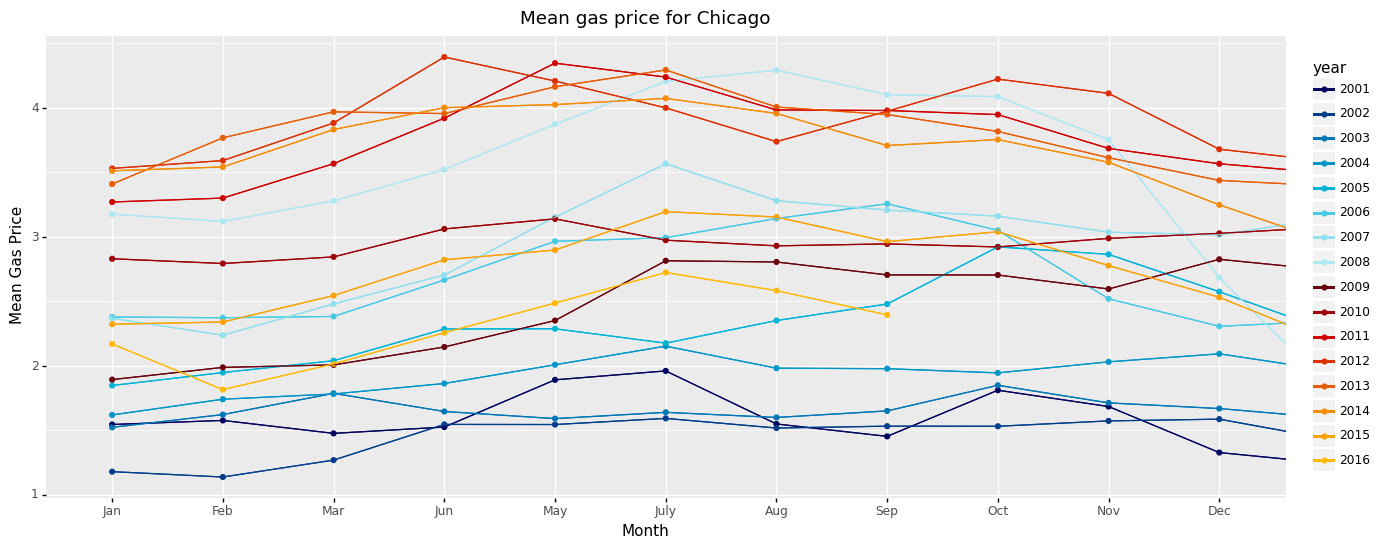

<ggplot: (315878925)>

In [15]:
(trains_hd_df[~trains_hd_df['is_holiday']]
 .assign(month=lambda df: df['date'].dt.month)
#  trains_df['date'].dt.month_name()
 .groupby(['year', 'month'])
 .mean()
 .reset_index()[
    ['year', 'month', GAS_PRICE_14_DAYS_LAG_COLUMN]
 ]
 .pipe(ggplot) +
    aes(x='month', y=GAS_PRICE_14_DAYS_LAG_COLUMN, color='year') +
    geom_line() +
    geom_point() +
    geom_path() +
    scale_x_discrete(
       name ="Month", 
      limits=["Jan", "Feb", "Mar", "Jun", "May", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
   ) +
   ggtitle("Mean gas price for Chicago") +
   ylab("Mean Gas Price") +
   scale_color_manual(values=[
      "#03045e", "#023e8a", "#0077b6", "#0096c7", "#00b4d8", "#48cae4", "#90e0ef", "#ade8f4",
      "#6a040f", "#9d0208", "#d00000", "#dc2f02", "#e85d04", "#f48c06", "#faa307", "#ffba08"
   ])
)

One thing we can explore is whether there is some correlation between ridership and 14 days lag of the gas price.

### **Ridership vs Gas price (14 days lag)** ⛽⛽⛽

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 8 rows containing missing values.


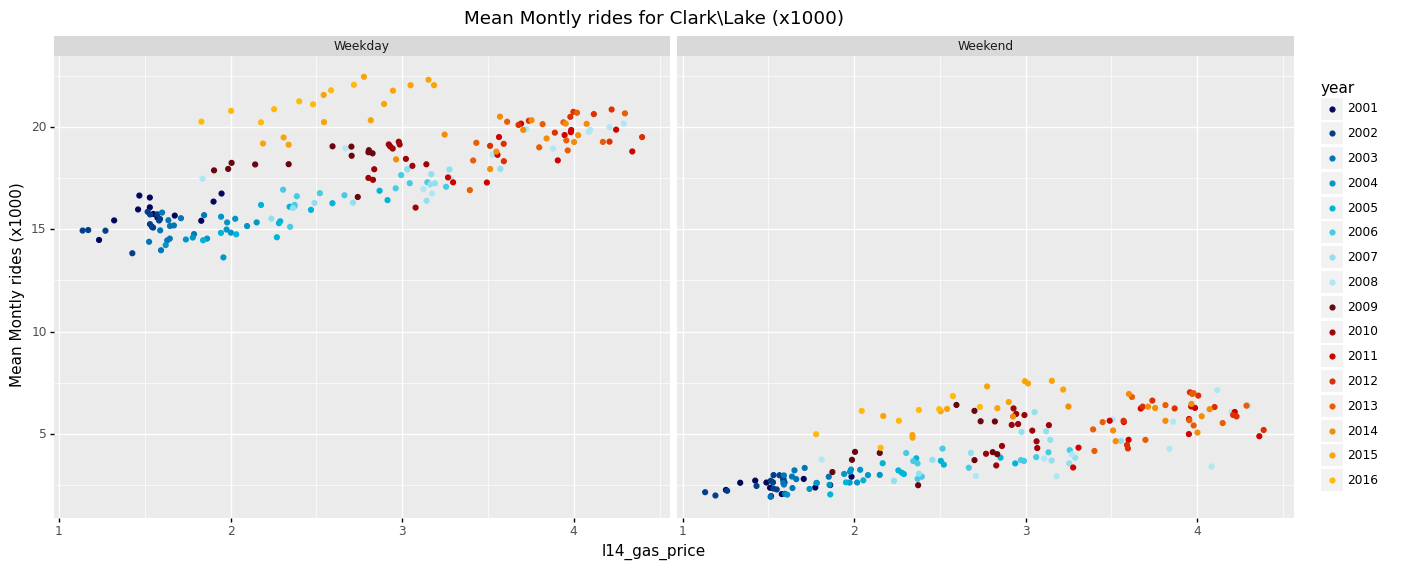

<ggplot: (315983074)>

In [16]:
ggplot_options.figure_size = (16, 6)

GAS_LAG_14_DAYS_COLUMN = 'l14_gas_price'

(trains_hd_df[~trains_hd_df['is_holiday']]
 .assign(month=lambda df: df['date'].dt.month)
#  trains_df['date'].dt.month_name()
 .groupby(['year', 'month', 'pow'])
 .mean()
 .reset_index()[
   ['year', 'month', 'pow', DAILY_RIDES_COLUMN, GAS_PRICE_14_DAYS_LAG_COLUMN]
  ]
 .pipe(ggplot) +
    aes(x=GAS_PRICE_14_DAYS_LAG_COLUMN, y=DAILY_RIDES_COLUMN, color='year') +
    geom_point() +
    facet_wrap('pow', ncol=2) +
    ggtitle("Mean Montly rides for Clark\\Lake (x1000)") +
    ylab("Mean Montly rides (x1000)") +
    scale_color_manual(values=[
      "#03045e", "#023e8a", "#0077b6", "#0096c7", "#00b4d8", "#48cae4", "#90e0ef", "#ade8f4",
      "#6a040f", "#9d0208", "#d00000", "#dc2f02", "#e85d04", "#f48c06", "#faa307", "#ffba08"
    ])
)

There is a positive association between the 2-week lag in gas price and the geometric mean of ridership.  From 2001 through 2014, the higher the gas price, the higher the ridership, with 2008 data appearing at the far right of both the Weekday and Weekend scatter plots. This trend is slightly different for 2015 and 2016 when oil prices dropped due to a marked increase in supply.

We can further explore this association with a simple linear regression.

# **Dimensionality Reduction (Many:Many Transformations)** 

We can visualize many dimensions using faceting, different colors, shapes and sizes, but at some point we'll be limited and wont be able to do that indefinitely.

Also, when creating new features from multiple predictors, there is a possibility of correcting a variety of issues such as outliers or collinearity. It can also help reduce the dimensionality of the predictor space in ways that might improve performance and reduce computational time for models.

One way we can deal with those problems is by projecting the predictors to a less dimensional space. The primary underlying assumption when using an unsupervised projection method is that the identified subspace is predictive of the response. This may or may not be true since the objective of unsupervised techniques is completely disconnected with the response. At the conclusion of model training, we may find that unsupervised techniques are convenient tools to condense the original predictors, but do not help to effectively improve predictive performance.

## **Linear Projection Methods**

- Principal Component Analysis (**PCA**)
- Kernel Principal Component Analysis (**KPCA**)
- Independent Component Analysis (**ICA**)
- Non-negative Matrix Factorization (**NNMF**)
- Partial Least Squares (**PLS**)
- Multidimensional Scaling (**MDS**)

We are looking for M vectors $\overrightarrow{Z_1}, ..., \overrightarrow{Z_M}$ s.t. 

$$
\overrightarrow{Z_m}=\sum_{j=1}^p{\phi_{jm}\overrightarrow{X_j}}
$$

So, in a matrix notation that would be 

$$
\mathbf{Z} = \mathbf{X} \mathbf{\Phi}
$$

That way we can reduce the number of predictors and express the response $\overrightarrow{Y}$ in the form

$$
Y = \theta_0 + \sum_{m=1}^M{\theta_m\overrightarrow{Z_m}} + \overrightarrow{\epsilon}
$$

which would in the end, require fitting only $M$ coefficients.

The above written in matrix form

$$
\overrightarrow{Y} = \begin{bmatrix}\overrightarrow{Z_1} & \cdots && \overrightarrow{Z_m}\end{bmatrix} \begin{bmatrix}\theta_1 \\ \cdots \\ \theta_M\end{bmatrix} + \overrightarrow{\epsilon}
$$

If we expand the Z matrix we get

$$
\overrightarrow{Y} =
\begin{bmatrix}
x_{11} & \cdots & x_{1p} \\ 
\cdots & \cdots & \cdots \\
x_{n1} & \cdots & x_{np} 
\end{bmatrix} 

\begin{bmatrix}
\phi_{11} & \cdots & \phi_{1M} \\ 
\cdots & \cdots & \cdots \\
\phi_{p1} & \cdots & \phi_{pM} 
\end{bmatrix} 
\begin{bmatrix}\theta_1 \\ \cdots \\ \theta_M\end{bmatrix} + \overrightarrow{\epsilon} = \mathbf{X} \mathbf{\Phi}\overrightarrow{\theta} + \epsilon
$$

It turns out that what we are looking for is a matrix (**linear transformation**) $\mathbf{\Phi}_{\{pM\}}$ with which to transform the predictor space to a subspace. This matrix is usually called the **Projection Matrix**.

<u>This notion of dimension reduction should not be confused with feature selection.</u> If the predictor space can be described with  
k score variables, there are less features in the data given to the model but each of these columns is a function of all of the original predictors.

Hence, our new form can be viewed as a special case of a linear regression, but introducing a bias and constrain on the coefficient forms. However, having a large $p$ and a much smaller $M$, we
can substantially reduce the variance of our model. One thing to have in mind is that employing an unsupervised technique does not guarantee an improvement in predictive performance.

All dimension reduction steps work in two steps
- Find $Z_1, ..., Z_M$
- The model is fit on those new predictors

However, the selection of $\Phi$ can be achieved in many ways. 

<br />

## **Principal Component Analysis**

When faced with a large set of correlated variables, **p**rincipal **c**omponents allows us to summarize this set with a smaller number of representative variables that collectively explain most of the variability in the original set.

**PCA** reduces the dimension of our design matrix **X**. The first principle component direction of our PCA is the direction in which the observations vary the most.

So, projecting our observations on the first component would give observations with maximal variance.

$$
Z_1 = \phi_{11}X_1 + \phi_{21}X_2 + \cdots
$$

The elements of $\Phi$ are known as **principal component loadings**.

**The idea is** that out of every possible linear combination of $X_1, \cdots X_p$ s.t. $\sum_{i=1}^p\phi_{i1}^2=1$ (norming), this particular linear combination yields the highest variance (**variation**), i.e. $\sum_{i=1}^p\phi_{i1}X_i$ is maximized.

<u>From a statistical perspective, variation is synonymous with information.</u>

So, by finding combinations of the original predictors that capture variation, we find the subspace of the data that contains the information relevant to the predictors. Simultaneously, the new PCA scores are required to be orthogonal (i.e., uncorrelated) to each other. The property of orthogonality enables the predictor space variability to be neatly partitioned in a way that does not overlap. It turns out that the variability summarized across all of the principal components is exactly equal to the variability across the original predictors. In practice, enough new score variables are computed to account for some pre-specified amount of the variability in the original predictors (e.g., 95%).

<u>An important side benefit of this technique is that the resulting PCA scores are uncorrelated.</u> This property is very useful for modeling techniques (e.g., multiple linear regression, neural networks, support vector machines, and others) that need the predictors to be relatively uncorrelated.

There's another interpretation of PCA, i.e. <u>the first principal component is closest to the observations and minimizes the sum of squared perpendicular distances between each point and the PC vector</u>.

<u>In a sense, minimizing orthogonal distance between the observations and the PC vector, and choosing direction that maximizes variance is the same.</u>

PCA serves for 
- Dimensionality reduction which later can be used for a supervised problem
- **E**xploratory **D**ata **A**nalysis

The general idea behind **PCA** is that each of the n observations lives in p-dimensional space, but not all of these dimensions are equally interesting. **PCA** seeks a small number of dimensions that are as interesting as possible, where the concept of interesting is measured by the amount that the observations vary along each dimension. Each of the dimensions found by **PCA** is a linear combination of the p features.

### **How do we compute the first principal component?**

Since we want to maximize the variance, we look to maximize the following equation (assuming our vectors are centered and scaled)

$$
max_{\overrightarrow{\phi}}{\frac{1}{n}\sum_{i=1}^n{z_{i1}^2}} = max_{\overrightarrow{\phi}}{\frac{1}{n}\sum_{i=1}^n{(\sum_{j=1}^p{\phi_{j1}x_{ij}})^2}} = \\
max_{\overrightarrow{\phi}}{\frac{1}{n}\sum_{i=1}^n{(<\overrightarrow{x_i}, \overrightarrow{\phi}>)^2}} \text{ subject to } \sum_{j=1}^p{\phi_{j1}^2}=1 
$$

Equivalently, writing this in matrix form gives
$$
\phi_1 = \argmax{||X\overrightarrow{\phi}||^2} = \argmax{\frac{\overrightarrow{\phi'X'X\phi}}{\phi'\phi}}
$$

We refer to $z_{11}, \cdots z_{n1}$ as the **scores of the first principal component**. The above problem can be solved (maximized) with an **Eigen Decomposition**.
The $\phi_1$ vector is the maximal eigen vector in the above decomposition and it's elements are known as the **loadings**. It is a combination of the axis vector and the explained variance (**eigen value**).

This makes sense, since we want to find vectors which maximize variance and finding an **Eigen Decomposition** on the Covariance Matrix does just that, i.e. finding an orthogonal space. Out of that subspace we can take the maximal vector columns and use them as our **Principal Components**.


In [17]:
train_stops_df = trains_df.filter(regex=("l14_[0-9]"))

pca = PCA()

# pipeline for scaling and pca-ing
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca)
])

# calculate the scores (projected Xs on the principal component scores)
scores_df = pd.DataFrame(
    # generate the scores by projecting the predictor space on the axes of the PC Decomposition
    pipeline.fit_transform(train_stops_df),
    # name the columns by according PC score
    columns=[f'principal_component_score_{i}' for i in range(1, 126)]
# add some indicator columns
).assign(
    dow=trains_df['dow'],
    pow=trains_df['pow'],
    year=trains_df['year'], axis=1
)

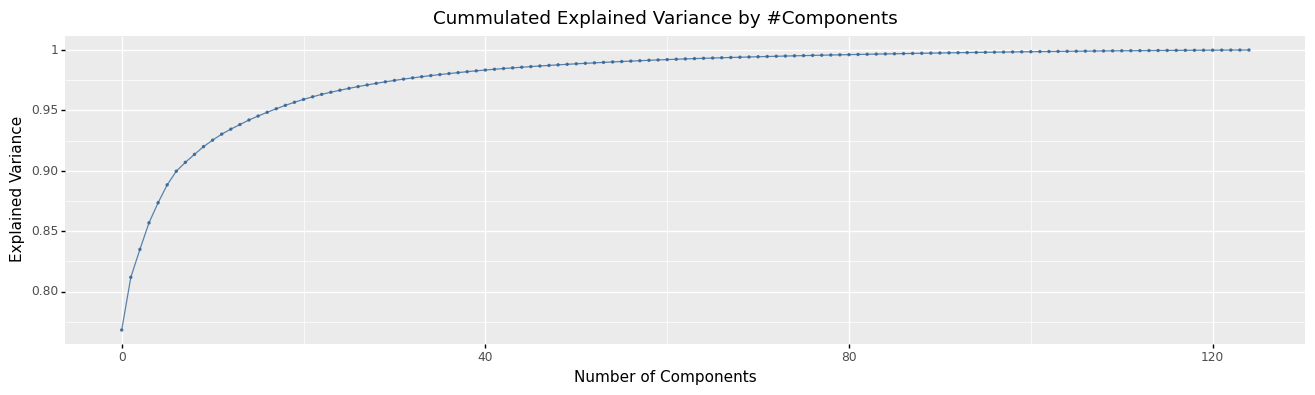

<ggplot: (315997567)>

In [18]:
ggplot_options.figure_size = (16, 4)

(pd.DataFrame({
    'x': range(125), 
    'explained_variance': pca.explained_variance_.cumsum() / pca.explained_variance_.cumsum().max()
}).pipe(ggplot) +
    aes(x='x', y='explained_variance') +
    geom_line(color="#336699", alpha=0.8) +
    geom_point(color="#336699", alpha=0.8, size=0.4) +
    xlab("Number of Components") +
    ylab("Explained Variance") +
    ggtitle("Cummulated Explained Variance by #Components")
)

Another way we can visualize the variance explained is using a **Scree Plot**

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 115 rows containing missing values.
/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 115 rows containing missing values.


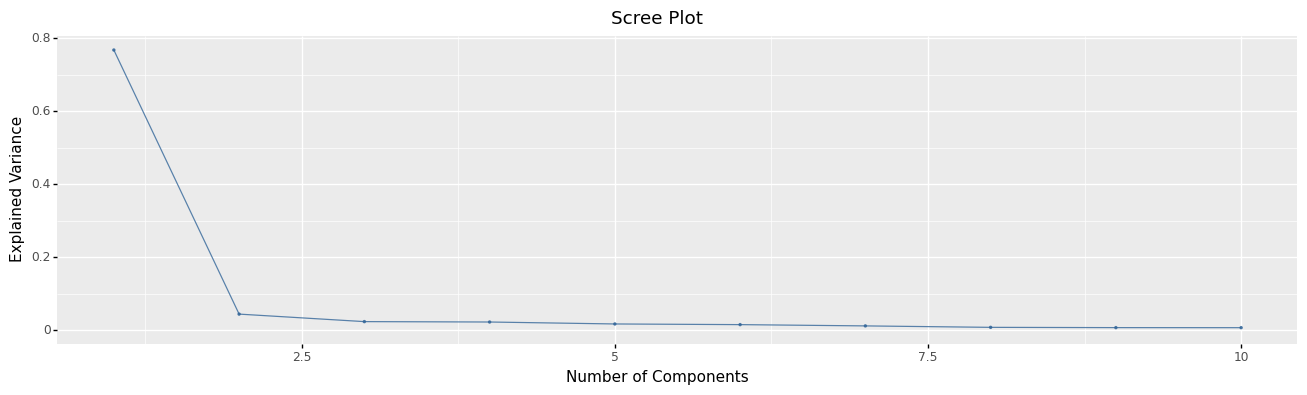

<ggplot: (318217442)>

In [19]:
(pd.DataFrame({
    'x': range(1, 126), 
    'explained_variance': pca.explained_variance_ratio_
}).pipe(ggplot) +
    aes(x='x', y='explained_variance') +
    geom_line(color="#336699", alpha=0.8) +
    geom_point(color="#336699", alpha=0.8, size=0.4) +
    xlab("Number of Components") +
    ylab("Explained Variance") +
    ggtitle("Scree Plot") +
    xlim([1, 10])
)

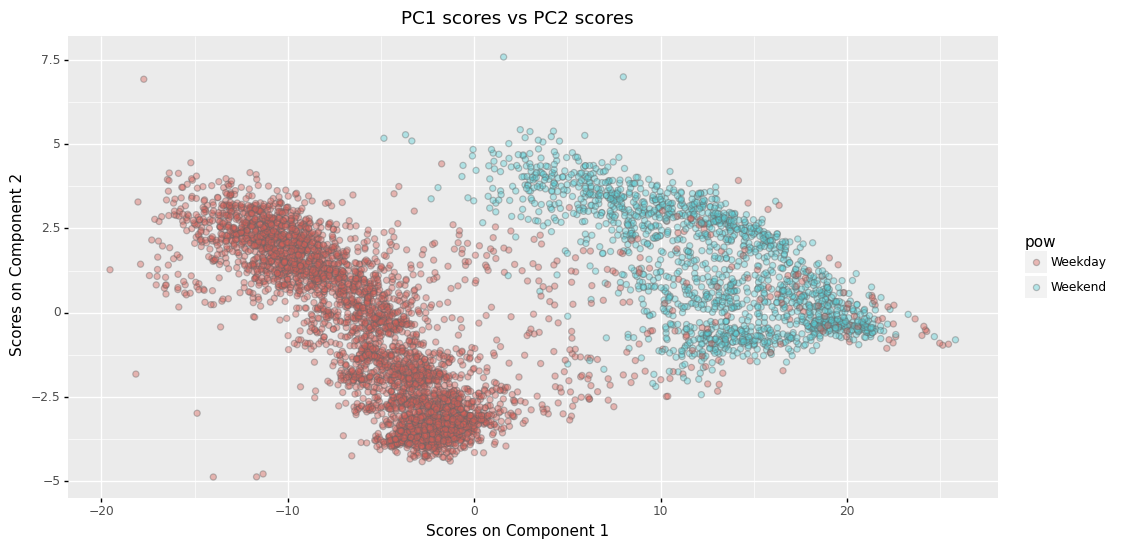

<ggplot: (315842353)>

In [20]:
ggplot_options.figure_size = (12, 6)

(ggplot(scores_df) +
    aes(x='principal_component_score_1', y='principal_component_score_2', fill='pow') +
    geom_point(alpha=0.4, color="#666666", size=2) +
    xlab("Scores on Component 1") +
    ylab("Scores on Component 2") +
    ggtitle("PC1 scores vs PC2 scores")   
)

Another way we can gain interpretation in the results of the PCA is using a Biplot of the loadings.

### **Biplot**

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


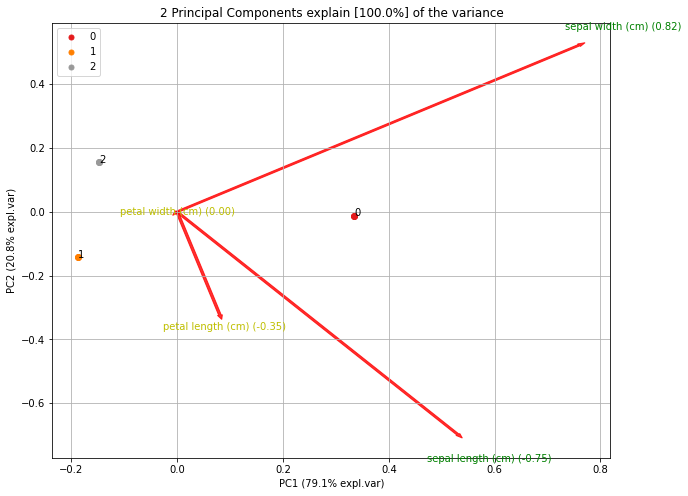

In [131]:
# Initialize to reduce the data up to the number of componentes that explains 95% of the variance.
iris = datasets.load_iris(as_frame=True)
X = pd.DataFrame(data=iris.data, columns=iris.feature_names, index=iris.target)
y = iris.target

# Or reduce the data towards 2 PCs
model = pca_helper(n_components=2)

# Fit transform
results = model.fit_transform(X)

# Make biplot with the number of features
fig, ax = model.biplot(n_feat=4)

<u>Another interpretation of the loadings is how much the predictors are correlated with our principal components. Using the iris data, we see that sepal width is having strongest effect on component 1. AFter that it's sepal length. </u>

### **Manual computation of scores through component loadings**

In [22]:
# component axes
loadings_component_1 = pca.components_[0]
loadings_component_2 = pca.components_[1]

dat = trains_df.filter(regex=("l14_[0-9]"))
X = StandardScaler().fit_transform(dat)

scores1 = X.dot(loadings_component_1) 
scores2 = X.dot(loadings_component_2)

pd.DataFrame({
    'my_scores': scores1,
    'sklearn_scores': scores_df['principal_component_score_1']
}).head(5)


,my_scores,sklearn_scores
0,-1.409079,-1.409079
1,-1.901288,-1.901288
2,-2.070550,-2.070550
3,-2.408477,-2.408477
4,-2.416006,-2.416006


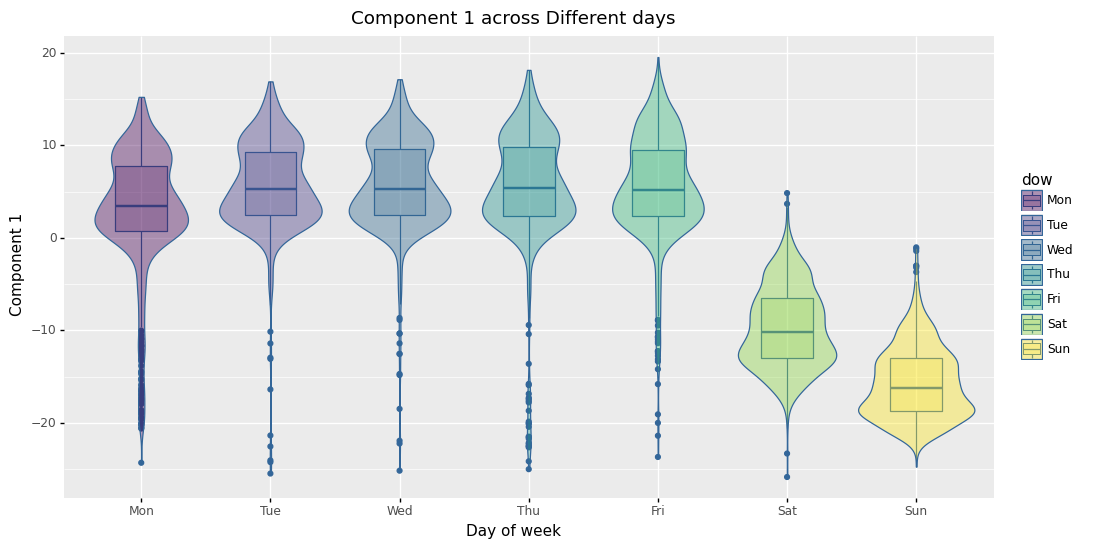

<ggplot: (318387435)>

In [23]:
scores_df['dow'] = pd.Categorical(scores_df['dow'], categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)

(scores_df
 .assign(principal_component_score_1 = lambda df: df['principal_component_score_1'] * -1)
 .pipe(ggplot) +
    aes(x='dow', y='principal_component_score_1', fill='dow') +
    # 🎻🎻🎻
    # geom_jitter(alpha=0.05) +
    geom_boxplot(alpha=0.2, color="#336699", width=0.4) +
    geom_violin(alpha=0.4, color="#336699") +
    xlab("Day of week") +
    ylab("Component 1") +
    ggtitle("Component 1 across Different days")   
)

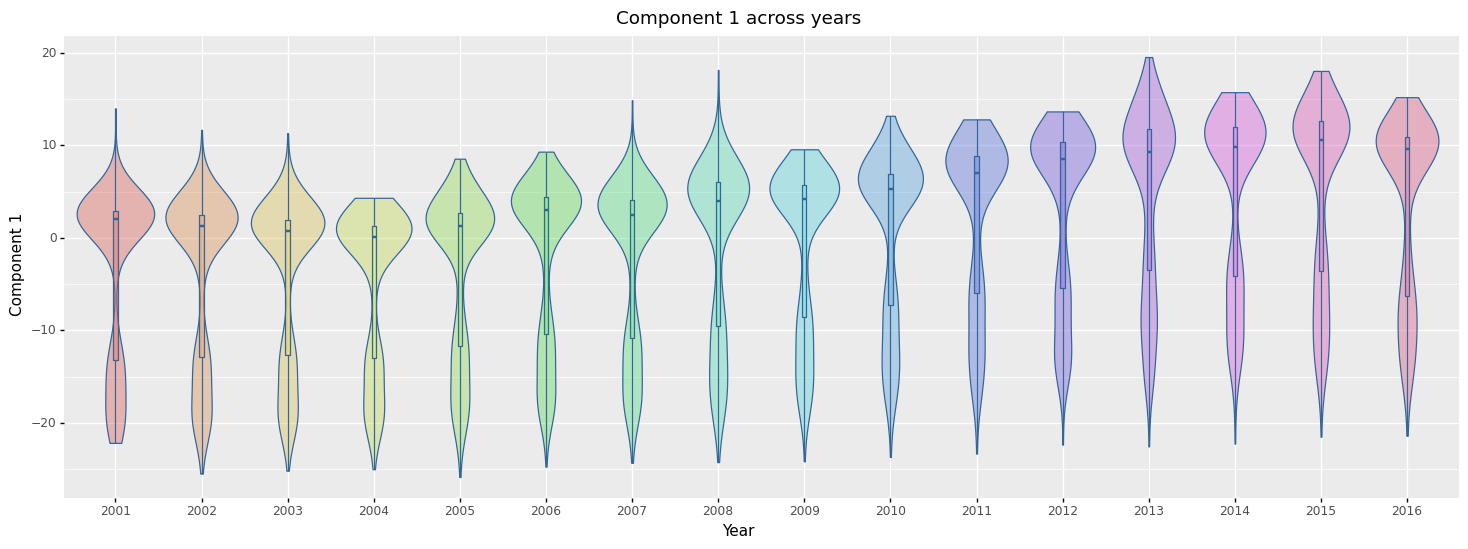

<ggplot: (315876572)>

In [24]:
ggplot_options.figure_size = (18, 6)

(scores_df
 .assign(principal_component_score_1 = lambda df: df['principal_component_score_1'] * -1)
 .pipe(ggplot) +
    aes(x='year', y='principal_component_score_1', fill='year') +
    geom_violin(alpha=0.4, color="#336699") +
    geom_boxplot(alpha=0.4, color="#336699", width=0.05) +
    xlab("Year") +
    ylab("Component 1") +
    ggtitle("Component 1 across years") +
    theme(legend_position='none')
)

### **Which station contributed most to the first few principal components**

In [129]:
# substring the station id in order to join later with loadings
stations_substr_df = stations_df[['name', 'station_id']].assign(
    station_id=lambda df: df.station_id.str.slice(2)
)

(pd.DataFrame({
    'loading_pc1': np.abs(loadings_component_1),
    'loading_pc2': np.abs(loadings_component_2),
    'station_id': train_stops_df.columns.str.slice(4, )
})
 # join\merge with the station names
 .pipe(pd.merge, stations_substr_df)
 .sort_values(by='loading_pc1', ascending=False)
 .head(10)[['name', 'loading_pc1']]
)

,name,loading_pc1
10,35th/Archer,0.100422
87,Ashland,0.100337
0,Austin,0.100191
5,Belmont,0.100152
14,Oak Park,0.100073
46,Irving Park,0.099544
114,Bryn Mawr,0.099398
25,Western,0.099079
110,Montrose,0.099056
82,Harlem,0.098998


## **Kernel Principal Component Analysis**

Principal component analysis is an effective dimension reduction technique when predictors are <u>linearly correlated</u> and when the <u>resulting scores are associated with the response</u>.

However, the orthogonal partitioning of the predictor space may not provide a good predictive relationship with the response, especially if the true underlying relationship between the predictors and the response is **non-linear**. Consider, for example

$$
y = x_1 + x_1^2 + x_2 + x_2^2 + \epsilon
$$

Suppose also that the correlation between $x_1$ and $x_2$ is really strong. Applying traditional PCA to this example would summarize the relationship between $x_1$ and $x_2$ into one principal component. However this approach would ignore the important quadratic relationships that would be critically necessary for predicting the response.

The inner-product is referred to as the linear kernel; the linear kernel between  
$x_1$ and $x_2$ is represented as:

$$
k(x_1, x_2) = <x_1, x_2> = x_1'x_2
$$

We can modify that with an alternative kernel function sustaining the inner product

$$
k(x_1, x_2) = <\phi(x_1)', \phi(x_2)>
$$

To illustrate this, lets simulate data using the formula above.



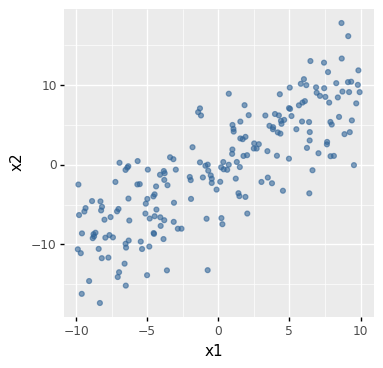

<ggplot: (315663439)>

In [273]:
x1 = np.random.uniform(-10, 10, 200)
x2 = x1 + np.random.normal(0, 4, 200)

error = np.random.normal(0, 6, 200)

y = x1 + x1**2 + x2 + x2**2 + error


df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

ggplot_options.figure_size = (4, 4)
ggplot(df) + aes(x='x1', y='x2') + geom_point(alpha=0.6, color="#336699")


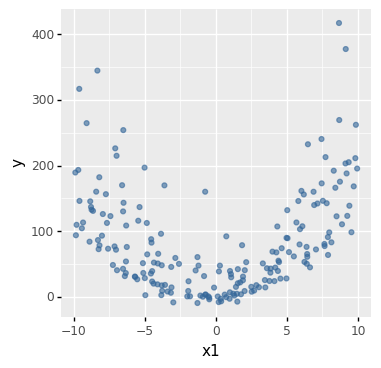

<ggplot: (319359205)>

In [276]:
ggplot(df) + aes(x='x1', y='y') + geom_point(alpha=0.6, color="#336699")

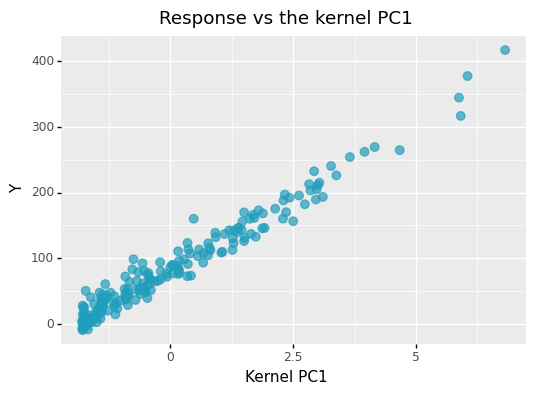

<ggplot: (318262128)>

In [381]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(df[['x1', 'x2']], df['y'])

# create a pca and a polynomial kernel PCA
pca = PCA()
kpca = KernelPCA(kernel='poly', degree=2, coef0=0, gamma=1)

kpca_pipeline = Pipeline([ ('scaler', StandardScaler()), ('pca', kpca)])

scores_df = pd.DataFrame(
    # generate the scores by projecting the predictor space on the axes of the PC Decomposition
    kpca_pipeline.fit_transform(df[['x1', 'x2']]),
    # name the columns by according PC score
    columns=[f'kpc_score_{i}' for i in range(1, 4)]
)

ggplot_options.figure_size = (6, 4)

(ggplot(scores_df) +
    aes(x='kpc_score_1', y='y') +
    geom_point(alpha=0.7, color="#219ebc", size=3) +
    xlab("Kernel PC1") +
    ylab("Y") +
    ggtitle("Response vs the kernel PC1")
)


/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_density : Removed 1 rows containing non-finite values.


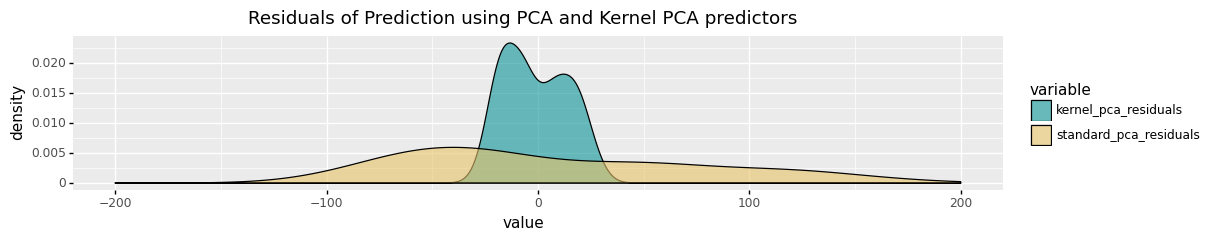

<ggplot: (318236389)>

In [389]:
# thats the way to add transforming to the response
scaled_regression = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

# pca pipeline
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca),
    ('linear_regression', scaled_regression)
])

# kpca pipeline
kpca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kpca', kpca),
    ('linear_regression', scaled_regression)
])

# fit and predict for pca
pca_pipeline.fit(X_train, y_train)
pca_residuals = y_test - pca_pipeline.predict(X_test)

# fit and predict for kernel pca
kpca_pipeline.fit(X_train, y_train)
kpca_residuals = y_test - kpca_pipeline.predict(X_test)

ggplot_options.figure_size = (12, 2)

# plot the distributions of the two residual vectors
(pd.DataFrame({
    'standard_pca_residuals': pca_residuals,
    'kernel_pca_residuals': kpca_residuals
}).melt().pipe(ggplot) +
    aes(x='value', fill='variable') +
    geom_density(alpha=0.6) +
    xlim(-200, 200) +
    ggtitle("Residuals of Prediction using PCA and Kernel PCA predictors") +
    scale_fill_manual(values=["#0a9396", "#e9c46a"])
)

## **Independent Component Analysis**


## **Visualizations for Categorical Data: Exploring the OkCupid Data Visualizing Categorical Data**

Again, for the purpose predicting whether someone is in the STEM field based on some predictors, we are going to explore visually just on on that.

### **Barplots**

Barplots, traditionally used for counting occurances can be used to plot the proportion of the STEM field in the okCupid data, based on different religions.

In [25]:
okc_train_df = pd.read_csv("./data/okc/okc_train.csv")
okc_test_df = pd.read_csv("./data/okc/okc_test.csv")
okc_down_df = pd.read_csv("./data/okc/okc_down.csv")
okc_sampled_df = pd.read_csv("./data/okc/okc_sampled.csv")

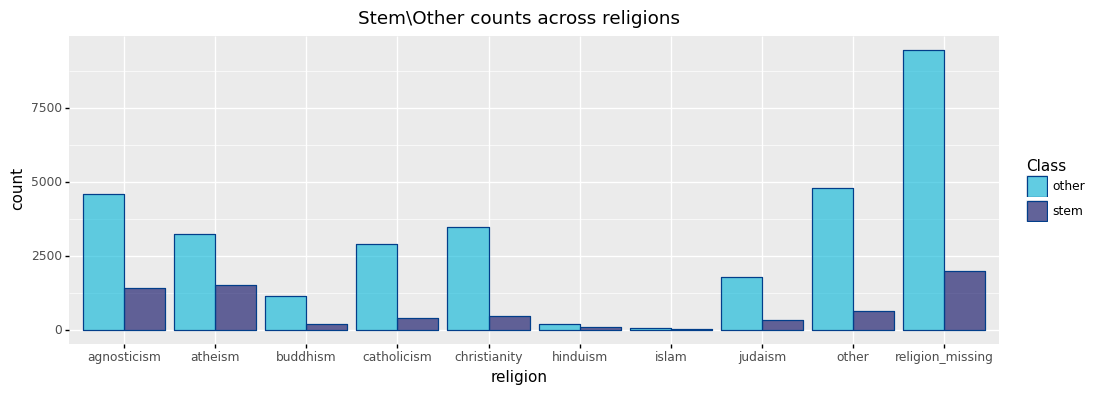

<ggplot: (315544239)>

In [26]:
ggplot_options.figure_size = (12, 4)

(ggplot(okc_train_df) +
    aes(x='religion', fill='Class') +
    geom_bar(position="dodge", color="#023e8a", alpha=0.6) +
    ggtitle("Stem\\Other counts across religions") +
    scale_fill_manual(values=["#00b4d8", "#03045e"])
)

There are some potential problems with trying to extract insights from this plot. 

- To understand if any religions are associated with the outcome, the reader’s task is to visually judge the ratio of each dark blue bar to the corresponding light blue bar across all religions and to then determine if any of the ratios are different from random chance. This figure is ordered from greatest ratio (left) to least ratio (right) which, in this form, may be difficult for the reader see.

- The plot is indirectly illustrating the characteristic of data that we are interested in, specifically, the ratio of frequencies between the STEM and non-STEM profiles. We don’t care how many Hindus are in STEM fields; instead, the ratio of fields within the Hindu religion is the focus. In other words, the plot obscures the statistical hypothesis that we are interested in: is the rate of Hindu STEM profiles different than what we would expect by chance?

- If the rate of STEM profiles within a religion is the focus, bar charts give no sense of uncertainty in that quantity. In this case, the uncertainty comes from two sources. First, the number of profiles in each religion can obviously affect the variation in the proportion of STEM profiles. This is illustrated by the height of the bars but this isn’t a precise way to illustrate the noise. Second, since the statistic of interest is a proportion, the variability in the statistic becomes larger as the rate of STEM profiles approaches 50% (all other things being equal).

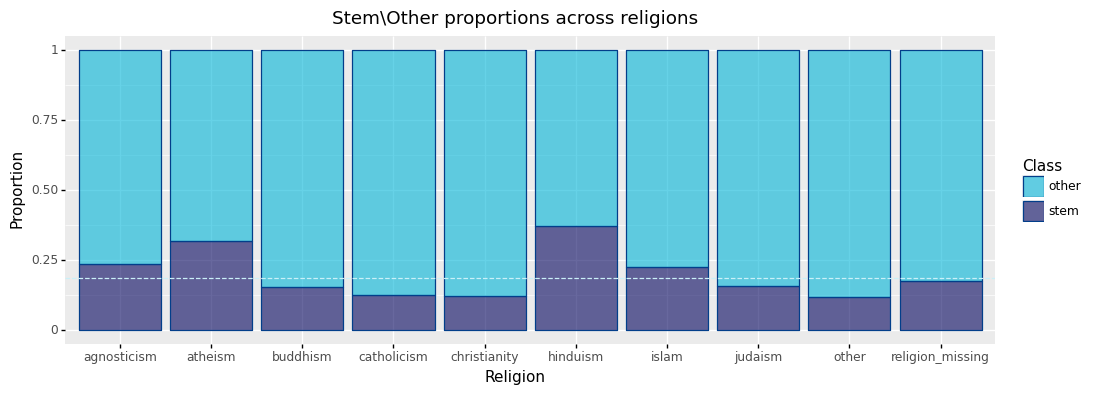

<ggplot: (318382038)>

In [27]:
ggplot_options.figure_size = (12, 4)

prop_stem = okc_train_df['Class'].value_counts(normalize=True)['stem']

(ggplot(okc_train_df) +
    aes(x='religion', fill='Class') +
    geom_bar(position="fill", color="#023e8a", alpha=0.6) +
    ggtitle("Stem\\Other proportions across religions") +
    scale_fill_manual(values=["#00b4d8", "#03045e"]) +
    geom_hline(yintercept=prop_stem, linetype='dashed', color="#caf0f8") +
    xlab("Religion") +
    ylab("Proportion")
)

However, we still haven't visualized the uncertainty of the proportions. Also, visualizing it like that, it is not clear whether the proportion in hinduisim and islam is not yet stabilized to it's real one due to lack of many observations. 

In [28]:
okc_train_df['religion'].value_counts()[['hinduism', 'islam']]

hinduism    301
islam        89
Name: religion, dtype: int64

We have only 89 islamish profiles and 301 hindu ones. Having so little observations, it's highly possible that the proprotion is due to chance.

We can use a Chi-square test for whether the proportion of stem\other proportion in the hindu group is the same as proportion in general.

In [29]:
from scipy.stats import chisquare

hindu_class = okc_train_df[okc_train_df['religion'] == 'hinduism']['Class']

observed = hindu_class.value_counts().values
exp = np.array([1-prop_stem, prop_stem]) * sum(observed)

pvalue = chisquare(f_obs=observed, f_exp=exp).pvalue
print("Our pvalue is: ")
pvalue


Our pvalue is: 


5.3053851348789726e-17

Our **pvalue** is extremely small, so I believe it's safe to assume we can reject the null hypothesis that the proportion is in the general sample.

One interpretation for that might be that, a great percentage of the indians in the US are in the STEM field and Hinduism is their major religion.

We still haven't visualized the variance of our classes. The following plot solves all of the three problems.

In [30]:
from statsmodels.stats.proportion import proportion_confint

# religions with counts for stem and non-stem
religion_class_df = (okc_train_df
 .groupby(['religion', 'Class'])
 .count()
 .reset_index()
)[['religion', 'Class', 'profile']]

# counts of all classes
religion_all_class_df = (religion_class_df
 .groupby('religion')
 .sum()
 .reset_index()
 .rename(columns={'profile': 'all'})
)

# join the two dataframes
religion_stem_and_all_counts_df = pd.merge(
    religion_class_df[religion_class_df['Class'] == 'stem'],
    religion_all_class_df
).rename(columns={'profile': 'stem'})[
    ['religion', 'stem', 'all']
].assign(proportion=lambda x: x['stem'] / x['all'])

lower_upper_series = religion_stem_and_all_counts_df.apply(
    lambda df: np.asarray(proportion_confint(df['stem'], df['all'])), 
    axis=1
)


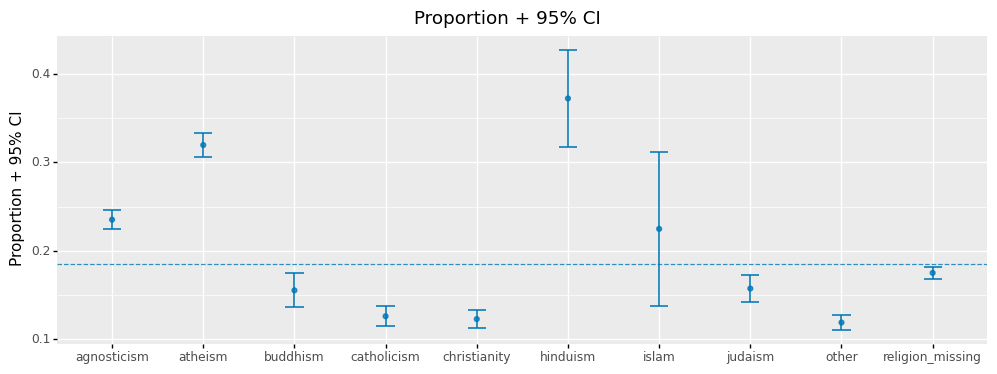

<ggplot: (315256706)>

In [31]:
(religion_stem_and_all_counts_df.assign(
    lower=lower_upper_series.apply(lambda x: x[0]),
    upper=lower_upper_series.apply(lambda x: x[1])
)
.pipe(ggplot) +
    aes(x='religion', y='proportion') +
    geom_point(color="#0077b6", alpha=0.8) +
    aes(x='religion', ymin='lower', ymax='upper') +
    geom_errorbar(width=.2, size=0.8, color="#0077b6", alpha=0.8) +
    geom_hline(yintercept=prop_stem, linetype='dashed', color="#0077b6", alpha=0.8) +
    xlab("") +
    ylab("Proportion + 95% CI") +
    ggtitle("Proportion + 95% CI") +
    theme(legend_position='none')
)

Now we have solved all of the three problems of barplots and shown what uncertainty there is with each religion's proportion of the STEM field.



> ### **The point of this discussion is not that summary statistics with confidence intervals are always the solution to a visualization problem. The takeaway message is that each graph should have a clearly defined hypothesis and that this hypothesis is shown concisely in a way that allows the reader to make quick and informative judgments based on the data.**

Finally, does religion appear to be related to the outcome? Since there is a gradation of rates of STEM professions between the groups, it would appear so. If there were no relationship, all of the rates would be approximately the same.

<hr>

### **How would one visualize the relationship between a categorical outcome and a numeric predictor?**

As an example, total length of all the profile essays will be used to illustrate a possible solution. 

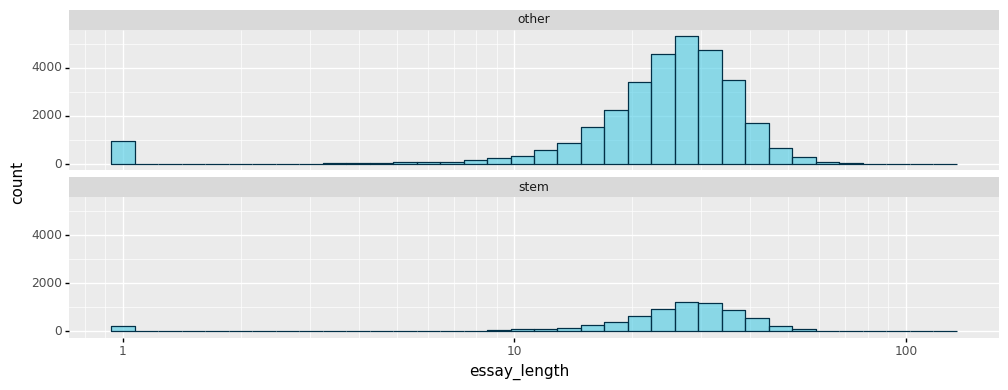

<ggplot: (315227344)>

In [32]:
ggplot_options.figure_size = (12, 4)

(okc_train_df
 .assign(essay_length=np.exp(okc_train_df['essay_length']))
 .pipe(ggplot) +
    aes(x='essay_length', fill='Class') +
    geom_histogram(binwidth=0.06, color="#023047", fill="#48cae4", alpha=0.6) +
    scale_x_log10() +
    facet_wrap('Class', nrow=2) +
    theme(legend_position='none')
)

The distributions appear to be extremely similar between classes so this predictor (in isolation) is unlikely to be important by itself. However, as discussed above, it would be better to try to directly answer the question.

To do this, another smoother is used to model the data. In this case, a regression spline smoother (Wood 2006) is used to model the probability of a STEM profile as a function of the (log) essay length. 

This involves fitting a logistic regression model using a basis expansion. This means that our original factor, log essay length, is used to create a set of artificial features that will go into a logistic regression model. The nature of these predictors will allow a flexible, local representation of the class probability across values of essay length 

## **Exploring Relationships Between Categorical Predictors**

The unfortunate practice that is often seen relies on a large number of basic statistical analyses of two-way tables that boil relationships down to numerical summaries such as the Chi-squared ( $\chi^2$) test of association. **Often the best approach is to visualize the data.**

When considering relationships between categorical data, there are several options.
- Once a cross-tabulation between variables is created, mosaic plots can once again be used to understand the relationship between variables. (e.g. drug - alcohol)

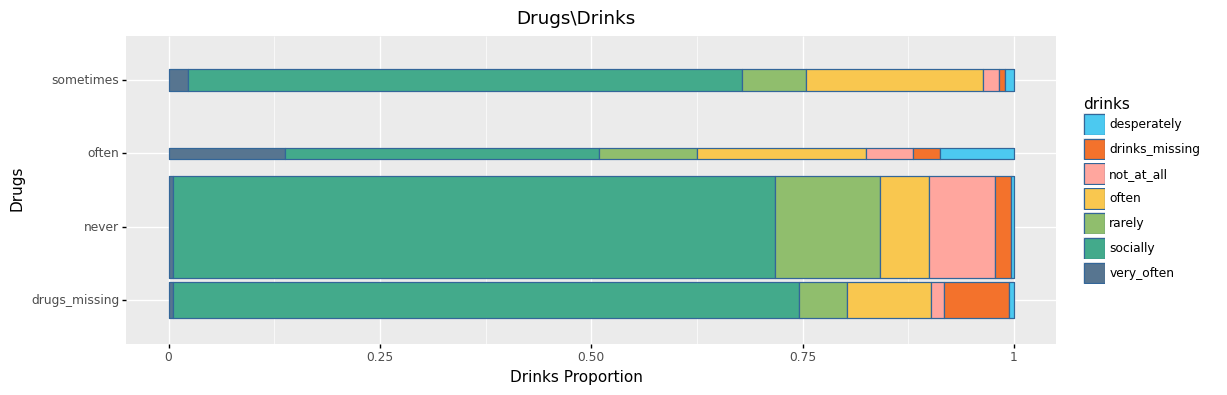

<ggplot: (315669757)>

In [33]:
total_drinks_props = (okc_train_df['drugs']
 .value_counts(normalize=True)
 .reset_index()
 .rename(columns={'index': 'drugs', 'drugs': 'total_prop'})
 .set_index('drugs'))

total_drinks_props.loc['often', 'total_prop'] = total_drinks_props.loc['often', 'total_prop'] * 10

drinks_drugs_props_df = (okc_train_df
 .groupby('drugs')['drinks']
 .value_counts(normalize=True)
 .rename('proportion')
 .reset_index()
 .join(total_drinks_props, how='left', on='drugs')
)

(drinks_drugs_props_df
 .assign(total_prop = drinks_drugs_props_df['total_prop'] * 2.2)
 .pipe(ggplot) +
    aes(x='drugs', y='proportion', fill='drinks', width="total_prop") +
    geom_bar(stat="identity", position="fill", color='#336699') +
    scale_fill_manual(values=["#4cc9f0", "#f3722c", "#ffa69e", "#f9c74f", "#90be6d", "#43aa8b", "#577590"]) +
    xlab("Drugs") +
    ylab('Drinks Proportion') +
    ggtitle("Drugs\\Drinks") +
    coord_flip()
)

Is there any relationship between these variables? Do any of the responses “cluster” with others?

## **Correspondence Analysis**

These questions can be answered using correspondence analysis (Greenacre 2017) where the cross-tabulation is analyzed.
It is conceptually similar to principal component analysis, but applies to categorical rather than continuous data.

The traditional  $χ^2$ test uses the deviations from these expected values to assess the association between the variables by adding up functions of this type of cell residuals. If the two variables in the table are strongly associated, the overall  $χ^2$ statistic is large. Instead of summing up these residual functions, correspondence analysis analyzes them to determine new variables that account for the largest fraction of these statistics42. These new variables, called the principal coordinates, can be computed for both variables in the table and shown in the same plot. These plots can contain several features:

- The data on each axis would be evaluated in terms of how much of the information in the original table that the principal coordinate accounts for. If a coordinate only captures a small percentage of the overall $\chi^2$ statistic, the patterns shown in that direction should not be over-interpreted.

- Categories that fall near the origin represent the “average” value of the data From the mosaic plot, it is clear that there are categories for each variable that have the largest cell frequencies (e.g., “never” drugs and “social” alcohol consumption). More unusual categories are located on the outskirts of the principal coordinate scatter plot.

- Categories for a single variable whose principal coordinates are close to one another are indicative of redundancy, meaning that there may be the possibility of pooling these groups.



- Categories in different variables that fall near each other in the principal coordinate space indicate an association between these categories.

![](./images/eda-ca-1.svg)


- Points near the center are near the mean, nothing irregular - Social, rare and never drinking with never drugs.
- Clusters indicate correlated categories - often drinking with sometimes taking drugs or often drugs with very often drinking
- Points away from the center are less frequent categories, like the drug abusers drinking too much.
- The Y axis (Dimension 2) is mainly for missing values indication. 
- The X axis (Dimension 1) can be interpreted as substance use.

<br />
<br />

## **Post Modeling Exploratory Data Analysis**

One way we can identify useful predictors is using the partial regression plot.

We fit a model

$$
y_i = \sum_{j=1}^p\beta_jx_{ij} + \epsilon_i
$$

Next we select a predictor that was not in the above model, i.e. $x_{\text{new}_i}$
$$
x_{\text{new}_i} = \sum_{j=1}^p\beta_jx_{ij} + \eta_i
$$

The **residuals** from the two models above are then **plotted against each other on a scatter plot**.
A **linear or curvi-linear pattern** between these sets of residuals are an indication that the new predictor as a linear or quadratic (or some other non-linear variant) term would be a useful addition in the model.

As previously mentioned, it is problematic to examine the model fit via residuals when those values are determined by simply pre-predicting the training set data. A better strategy is to use the residuals from the various **assessment sets** created during **resampling**.

We can plot that with **statsmodels.graphics.regressionplots.plot_partregress**